# Named Entity Recognition using LSTM model


Named-entity recognition (NER) is a subtask of information extraction that seeks to locate and classify named entity mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

In [1]:
import pandas as pd
pd.options.display.max_rows = 4000
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
!pip install sklearn_crfsuite
from sklearn_crfsuite.metrics import flat_classification_report
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input,Sequential
from keras.layers import LSTM, Dense, Embedding, Bidirectional
path="Enter Dataset Path Here"

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
#Reading the csv file
data = pd.read_csv(path+'ner_dataset.csv', encoding = "ISO-8859-1")
data.head(40)

,Unnamed: 0,Sentence #,Word,POS,Tag
0,0,Sentence: 1,Thousands,NNS,O
1,1,NaN,of,IN,O
2,2,NaN,demonstrators,NNS,O
3,3,NaN,have,VBP,O
4,4,NaN,marched,VBN,O
5,5,NaN,through,IN,O
6,6,NaN,London,NNP,B-geo
7,7,NaN,to,TO,O
8,8,NaN,protest,VB,O
9,9,NaN,the,DT,O




*   ```Sentence # =id of sentence.```
*   ```Word represents word of sentence.```
*  ```POS represents part of speech of sentence.```
*   ```Tag represents tag of word.```<br>

**Fill NaN values**<br>


---



>*   ```There are lots of missing values in 'Sentence #' attribute.``` <br>```So we will use 'ffill' method which propagates last valid observation forward to next.```
>*   ```'ffill' stands for 'forward fill'```




In [0]:
data["Sentence #"]=data["Sentence #"].fillna(method='ffill')


```To understand more about the DataFrame,check below code and see how sentences can be reformed from the DataFrame.```




In [5]:
sentences_list=data.groupby("Sentence #").apply(lambda a :a["Word"].tolist())
i=1
print("The {} sentence is ".format(i))
print(" ".join(sentences_list[i]))

The 1 sentence is 
Iranian officials say they expect to get access to sealed sensitive parts of the plant Wednesday , after an IAEA surveillance system begins functioning .


In [6]:
data.describe()

,Unnamed: 0
count,1.048575e+06
mean,5.242870e+05
std,3.026977e+05
min,0.000000e+00
25%,2.621435e+05
50%,5.242870e+05
75%,7.864305e+05
max,1.048574e+06


**Verification Check For NULL Values**

---



In [7]:
data.isnull().sum()

Unnamed: 0    0
Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

**Class Distribution**

---



In [8]:
print("Total number of labels possible are ",len(data['Tag'].value_counts()))
data['Tag'].value_counts()

Total number of labels possible are  11


O        889420
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
I-gpe       198
Name: Tag, dtype: int64

```B- stands Beginning of Tag Phrase```<br>


```I-stands for inside of Tag Phrase.```<br>
```e.g. For entity "International Atomic Energy >Agency"```<br>
```Tagging goes like this```<br>
>```International - B-org``` <br>
>```Atomic - I-org```<br>
>```Energy - I-org```<br>
>```Agency - I-org```<br>

```Entities abbreviations :-```<br>

>*   ```geo = Geographical Entity```
>*   ```org = Organization```
>*   ```per = Person```
>*   ```gpe = Geopolitical Entity```
>*   ```tim = Time indicator```









```
See what words have been tagged with which Tags.
```



In [9]:
from collections import Counter
tag_word_list=data.groupby("Tag").apply(lambda a :a["Word"].tolist())
for i in data["Tag"].unique():
  print(i,Counter(tag_word_list[i]).most_common(10))

O [('the', 52343), ('.', 47761), (',', 32476), ('in', 26199), ('of', 25127), ('to', 23095), ('a', 20481), ('and', 19228), ('The', 11038), ("'s", 10535)]
B-geo [('U.S.', 3169), ('Iraq', 1666), ('United', 1259), ('Iran', 1243), ('China', 908), ('Israel', 891), ('Afghanistan', 825), ('Pakistan', 733), ('Baghdad', 713), ('Russia', 554)]
B-gpe [('Iraqi', 1137), ('Palestinian', 988), ('Israeli', 987), ('Afghan', 814), ('British', 568), ('American', 539), ('Russian', 518), ('Pakistani', 466), ('Chinese', 453), ('Iranian', 380)]
B-per [('Mr.', 3085), ('President', 2411), ('Prime', 783), ('Minister', 197), ('Ms.', 176), ('John', 160), ('General', 139), ('Saddam', 119), ('Secretary', 98), ('Senator', 93)]
I-geo [('States', 1255), ('Korea', 477), ('Strip', 195), ('York', 185), ('of', 184), ('East', 181), ('Africa', 177), ('City', 144), ('Union', 120), ('Afghanistan', 114)]
B-org [('U.S.', 847), ('United', 728), ('U.N.', 547), ('Taleban', 542), ('NATO', 471), ('European', 448), ('al-Qaida', 397), 

**Histogram representation of Labels/Classes**

---



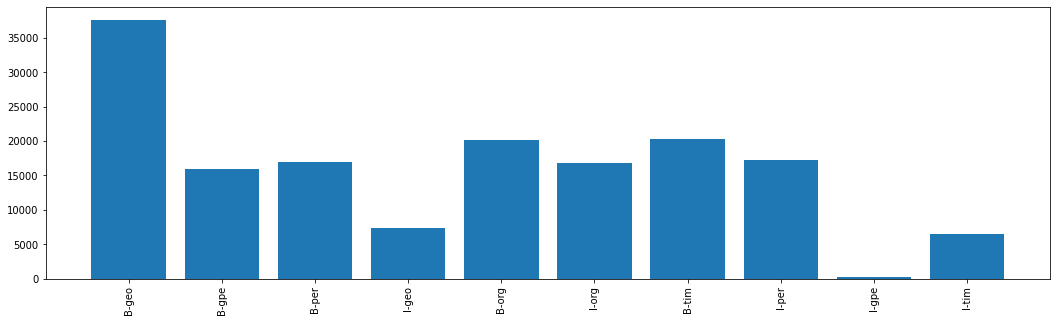

In [10]:
data.Tag.value_counts()
coun=Counter(" ".join(data[data["Tag"]!="O"]["Tag"]).split())
words= [x for x in coun]
values= [coun[x] for x in coun]
f, ax = plt.subplots(figsize=(18,5))
plt.bar(range(len(values)), values, align='center')
plt.xticks(range(len(words)), words, rotation='vertical')
plt.show()

**Sentence Class**

---



*   ```A Class to get sentences from the DataFrame with POS Tag and Labels.```

*   ```Each word will be in the form of tuple ,(Word,POS Tag,Labels).```



In [0]:
class sentence(object):
    def __init__(self, df):
        self.n_sent = 0
        self.df = df
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s=self.sentences[self.n_sent]
            self.n_sent +=1
            return s
        except:
            return None

In [12]:
getter = sentence(data)
print(getter.get_text())
# getter.grouped

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


Getting all the sentences from the data in the above form

In [0]:
sentences=getter.sentences

**Hyperparameter** 

In [0]:
num_of_epochs = 10
max_len = 75 
batch_size=32
embedding = 40 

**Preparing Inputs**
<br>

---


>```"word_to_index" is a dictionary that will map every unique word into an unique integer.```<br>
>```The integer 0 is used to represent padded word and 1 is used to represent Unknown/Unseen/New words on test data.```<br><br>
>```"tag_to_index" is a dictionary which  mas every unique tag into an unique integer.```<br>
>```Again,The integer 0 is used to represent tags for padded word```.<br><br>
>```"idx_to_word" is a dictionary which  mas integers back to original word as in word_to_index.```<br>
>```The integer 0 will be converted to "PAD" i.e.padded word.```<br>
>```The integer 1 will be converted to "UNK" i.e.Unknown word.```


In [0]:
words = list(data['Word'].unique())
words = list(data['Word'].unique())
tags = list(data['Tag'].unique())


word_to_index = {w : i+2 for i, w in enumerate(words)}#0 in padding is different from  word at 0.
word_to_index["UNK"] = 1                              #UNK=Unknown Word            
word_to_index["PAD"] = 0                              #PAD=Padded Number      

tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0                                #Padded Word's Tag

idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

**Sentences into input Sequences**<br>
>```word_to_index is used to map each word of sentence to a corresponding integer.```<br>
>```pad_sequences will make every sequence to the fixed length by appending zeros at the end.```

In [0]:
# Converting each sentence into list of index from list of tokens
X = [[word_to_index[w[0]] for w in s] for s in sentences]

# Padding each sequence to have same length  of each word
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = 0)

**Output Tag to MultiClass Output Tag Sequence**<br>
>```tag_to_index is used to map tag to integer.```<br>
>```pad_sequences is used make all output sequences of fixed length as Input Sequences.```<br>
>```to_categorical converts the output sequence to multi class output.```<br>
>```For each word, We have output sequence where output can be any of 18 tags.``` 

In [0]:
y = [[tag_to_index[w[2]] for w in s] for s in sentences]

y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = 0)

num_tag = data['Tag'].nunique()
y = [to_categorical(i, num_classes = num_tag+1) for i in y]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [19]:
print("Size of training input data : ", X_train.shape)
print("Size of training output data : ", np.array(y_train).shape)
print("Size of testing input data : ", X_test.shape)
print("Size of testing output data : ", np.array(y_test).shape)

Size of training input data :  (40765, 75)
Size of training output data :  (40765, 75, 12)
Size of testing input data :  (7194, 75)
Size of testing output data :  (7194, 75, 12)


```Sentence before and after processing.```


In [20]:
print('*****Before Processing  sentence : *****\n',sentences[14],"\n" ,' '.join([w[0] for w in sentences[14]]))
print('\n*****After Processing Input sequence : *****\n ', X_train[14])

*****Before Processing  sentence : *****
 [('The', 'DT', 'O'), ('global', 'JJ', 'O'), ('financial', 'JJ', 'O'), ('crisis', 'NN', 'O'), ('has', 'VBZ', 'O'), ('left', 'VBN', 'O'), ('Iceland', 'NNP', 'B-org'), ("'s", 'POS', 'O'), ('economy', 'NN', 'O'), ('in', 'IN', 'O'), ('shambles', 'NNS', 'O'), ('.', '.', 'O')] 
 The global financial crisis has left Iceland 's economy in shambles .

*****After Processing Input sequence : *****
  [ 4193 15087   570   504    80   602    11  1181     9   951  2573  3229
    21   160  4440    11  1699  1244  2181     9  7648    47  8249     9
 10265 10266    95    30  5220   324   876    33   982   645  6659    65
   498 10268  1490    23     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]


```Labels before and after processing```

In [21]:
print('*****Before Processing output : *****\n', ' '.join([w[2] for w in sentences[14]]))
print('\n*****After Processing output sequence : *****\n ', y[14],"\n")
print("\nGetting padded output sequence from output sequence")
print([idx2tag[np.argmax(x)] for x in y[14]])

*****Before Processing output : *****
 O O O O O O B-org O O O O O

*****After Processing output sequence : *****
  [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 

**Model**<br>
```A Sequential model that processes sequences of integers.```<br>
>```Embedding Layer embeds each integer into a 100-dimensional vector,```<br>
>```then sequence of vectors are processed using LSTM layer.```<br>
>```LSTM process each word one by one and output something (the state) at each step(after each word processed).```<br>
>```Dense Layer Transforms the information coming from LSTM for each word into 12 classes.```

In [93]:
model = Sequential()
model.add(Embedding(len(words)+2,50,input_length=max_len))
model.add(LSTM(100,return_sequences=True, dropout_U = 0.5, dropout_W = 0.5))
model.add(Dense(len(tags)+1,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()
history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=num_of_epochs,
                    validation_split=0.3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)`
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 75, 50)            1759000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 75, 100)           60400     
_________________________________________________________________
dense_3 (Dense)              (None, 75, 12)            1212      
Total params: 1,820,612
Trainable params: 1,820,612
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 28535 samples, validate on 12230 samples
Epoch 1/10
28535/28535 [==============================] - 92s 3ms/step - loss: 0.2456 - accuracy: 0.9436 - val_loss: 0.0993 - val_accuracy: 0.9708
Epoch 2/10
28535/28535 [==============================] - 92s 3ms/step - loss: 0.0750 - accuracy: 0.9797 - val_loss: 0.0532 - val_accuracy: 0.9863
Epoch 3/10
28535/28535 [==============================] - 92s 3ms/step - loss: 0.0453 - accuracy: 0.9877 - val_loss: 0.0424 - val_accuracy: 0.9878
Epoch 4/10
28535/28535 [==============================] - 90s 3ms/step - loss: 0.0361 - accuracy: 0.9894 - val_loss: 0.0392 - val_accuracy: 0.9883
Epoch 5/10
28535/28535 [==============================] - 90s 3ms/step - loss: 0.0317 - accuracy: 0.9903 - val_loss: 0.0380 - val_accuracy: 0.9885
Epoch 6/10
28535/28535 [==============================] - 91s 3ms/step - loss: 0.0290 - accuracy: 0.9909 - val_loss: 0.0372 - val_accuracy: 0.9887
Epoch 7/10
28535/28535 [==============================] - 92s 3ms/st



```
Training and validation accuracy
```



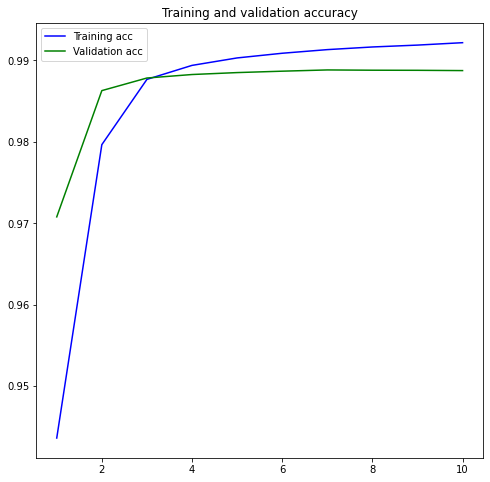

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

It can be observed that after 3 epochs , the model started overfitting as the separation between training accuracy and validation accuracy started increasing after 3rd epoch.



```
Training and validation loss
```



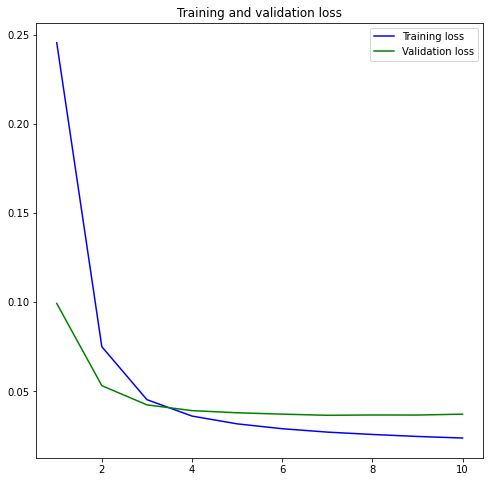

In [95]:
plt.figure(figsize = (8, 8))
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

Again It can be observed that after 3 epochs , the model started overfitting as the separation between training loss kept on decreasing but validation loss did not show much changes.

In [96]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

              precision    recall  f1-score   support

       B-geo       0.83      0.85      0.84      5625
       B-gpe       0.94      0.94      0.94      2459
       B-org       0.68      0.63      0.65      3070
       B-per       0.83      0.79      0.81      2632
       B-tim       0.91      0.82      0.86      2989
       I-geo       0.82      0.75      0.78      1081
       I-gpe       1.00      0.56      0.72        25
       I-org       0.78      0.74      0.76      2601
       I-per       0.85      0.84      0.85      2711
       I-tim       0.81      0.68      0.74       968
           O       0.98      0.99      0.99    133320
         PAD       1.00      1.00      1.00    382069

    accuracy                           0.99    539550
   macro avg       0.87      0.80      0.83    539550
weighted avg       0.99      0.99      0.99    539550




*   Precision of 1 means number of False Positive = 0.
*   Recall of 1 means number of False Negative = 0.
*   I-gpe has precision = 1, means when the model predicts "I-gpe".Hence, it must be the "I-gpe" tag.
<br>This inference can also be used to predict "B-gpe". 
*   But I-gpe has recall = .56, means when the model predicts any tag other than "I-gpe" , it still can be the "I-gpe" tag.
*   LSTM is able to achieve  a precision of 1 for few tags, which **CRF** model could not.
*   The "support" indicates number of obervations correspondingly which is very less for "I-gpe".<br>Hence, accuracy is very less for this Tag.



In [30]:
print(model.layers[0].output.shape)
print(model.layers[1].output.shape)
print(model.layers[2].output.shape)

(None, 75, 100)
(None, 75, 120)
(None, 75, 12)


**BI Directional LSTM**
>```It is a type of LSTM which learns from the input sequence from both forward and backward directions.```<br>
>```Bidirectional will copy the RNN layer passed in, and flip the go_backwards field of the newly copied layer, so that it will process the inputs in reverse order.```<br>
>```The output of the Bidirectional RNN will be, by default, the concatenation of the forward layer output and the backward layer output.```<br>
>```Bi-LSTM process each word one by one and output something (the state) at each step(after each word processed) for both forward and backward sequences.```<br>
>```Dense Layer Transforms the information coming from LSTM for each word into 12 classes as Dense is default applied to only last dimension.```

In [31]:
model_bi_lstm=Sequential()
model_bi_lstm.add(Embedding(input_dim = len(words) + 2, output_dim = 50,input_length=max_len))
model_bi_lstm.add(Bidirectional(LSTM(units = 100, return_sequences=True,dropout_U = 0.5, dropout_W = 0.5)))
model_bi_lstm.add(Dense(len(tags)+1, activation="softmax"))
model_bi_lstm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model_bi_lstm.summary()
history = model_bi_lstm.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=num_of_epochs,
                    validation_split=0.3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=100, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)`
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 75, 50)            1759000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 200)           120800    
_________________________________________________________________
dense_2 (Dense)              (None, 75, 12)            2412      
Total params: 1,882,212
Trainable params: 1,882,212
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 28535 samples, validate on 12230 samples
Epoch 1/10
28535/28535 [==============================] - 146s 5ms/step - loss: 0.1947 - accuracy: 0.9524 - val_loss: 0.0785 - val_accuracy: 0.9777
Epoch 2/10
28535/28535 [==============================] - 147s 5ms/step - loss: 0.0550 - accuracy: 0.9843 - val_loss: 0.0411 - val_accuracy: 0.9878
Epoch 3/10
28535/28535 [==============================] - 147s 5ms/step - loss: 0.0343 - accuracy: 0.9898 - val_loss: 0.0357 - val_accuracy: 0.9893
Epoch 4/10
28535/28535 [==============================] - 147s 5ms/step - loss: 0.0278 - accuracy: 0.9916 - val_loss: 0.0342 - val_accuracy: 0.9898
Epoch 5/10
28535/28535 [==============================] - 147s 5ms/step - loss: 0.0244 - accuracy: 0.9924 - val_loss: 0.0328 - val_accuracy: 0.9902
Epoch 6/10
28535/28535 [==============================] - 147s 5ms/step - loss: 0.0221 - accuracy: 0.9930 - val_loss: 0.0327 - val_accuracy: 0.9902
Epoch 7/10
28535/28535 [==============================] - 148s



```Training and validation accuracy```



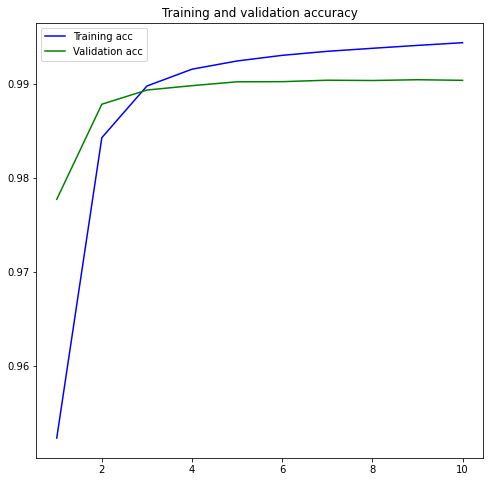

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

It can be observed that after 3 epochs , the model started overfitting as the separation between training accuracy and validation accuracy started increasing after 3rd epoch. <br>
Also,
within the 3 epochs , Bi -LSTM model is able to achieve higher accuracy than simple LSTM.
<br>But it also took more time to process the sequences.




```Training and validation loss```



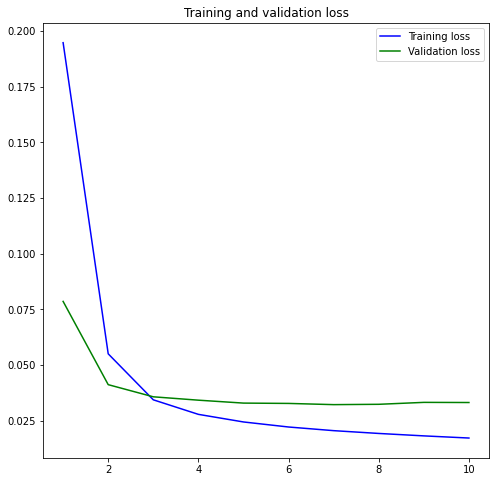

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [34]:
y_pred = model_bi_lstm.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

              precision    recall  f1-score   support

       B-geo       0.85      0.88      0.87      5625
       B-gpe       0.95      0.94      0.94      2459
       B-org       0.79      0.69      0.74      3070
       B-per       0.84      0.79      0.81      2632
       B-tim       0.91      0.88      0.89      2989
       I-geo       0.78      0.80      0.79      1081
       I-gpe       1.00      0.56      0.72        25
       I-org       0.78      0.78      0.78      2601
       I-per       0.85      0.83      0.84      2711
       I-tim       0.84      0.74      0.79       968
           O       0.99      0.99      0.99    133320
         PAD       1.00      1.00      1.00    382069

    accuracy                           0.99    539550
   macro avg       0.88      0.82      0.85    539550
weighted avg       0.99      0.99      0.99    539550



*   Precision and Recall scores are changed now which indicates predicting False Positives and False Negatives.
*   This scores tells confidence about the predicton and can be helpful as according to the importance of the tags.



In [35]:
print(model_bi_lstm.layers[0].output.shape)
print(model_bi_lstm.layers[1].output.shape)
print(model_bi_lstm.layers[2].output.shape)

(None, 75, 50)
(None, 75, 200)
(None, 75, 12)


**Random Prediction**

In [111]:
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_test)
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set) \n".format(i, X_test.shape[0]))
print("{:30}!!{:18}!!{}".format("Word", "Actual Tag ", "Predicted Tag"))
print(65 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:35}{:23}{}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 1833 of 7194 (Test Set) 

Word                          !!Actual Tag        !!Predicted Tag
He                                 O                      O
also                               O                      O
rejected                           O                      O
any                                O                      O
dialogue                           O                      O
with                               O                      O
the                                O                      O
main                               O                      O
Kurdish                            O                      O
political                          O                      O
group                              O                      O
,                                  O                      O
the                                O                      O
Democratic                         B-org                  B-org
Society                            I-org          

In [112]:
p = model_bi_lstm.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set) \n".format(i, X_test.shape[0]))
print("{:30}!!{:18}!!{}".format("Word", "Actual Tag ", "Predicted Tag"))
print(65 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:35}{:23}{}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 1833 of 7194 (Test Set) 

Word                          !!Actual Tag        !!Predicted Tag
He                                 O                      O
also                               O                      O
rejected                           O                      O
any                                O                      O
dialogue                           O                      O
with                               O                      O
the                                O                      O
main                               O                      O
Kurdish                            O                      O
political                          O                      O
group                              O                      O
,                                  O                      O
the                                O                      O
Democratic                         B-org                  B-org
Society                            I-org          

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**```END!```**